In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
N = 16
two_N = 32
nearest_square = 36
sqrt_N = 6

n = torch.arange(nearest_square)
omegas = torch.exp(2j * torch.pi * n / nearest_square)

In [5]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += str(poly[i])
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [6]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += str(poly[i])
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [8]:
def new_monarch(nearest_square, sqrt_N):
    r_polys = [
        [
            torch.rand(i).numpy().tolist() + [1]
            for i in range(sqrt_N)
        ]
        for j in range(sqrt_N)
    ]
    l_polys = [
        torch.rand(j).numpy().tolist() + [1]
        for j in range(sqrt_N)
    ]
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    for i in range(sqrt_N):
        block = torch.zeros(sqrt_N, sqrt_N)
        for j in range(sqrt_N):
            block[:, j] = torch.tensor(np.polyval(r_polys[i][j], omegas[::sqrt_N]))
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block
    for j in range(sqrt_N):
        for i in range(sqrt_N):
            L[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.tensor(np.polyval(l_polys[j], omegas[i * sqrt_N:(i + 1) * sqrt_N])))
    M = L @ R

    return L, R, M, r_polys, l_polys

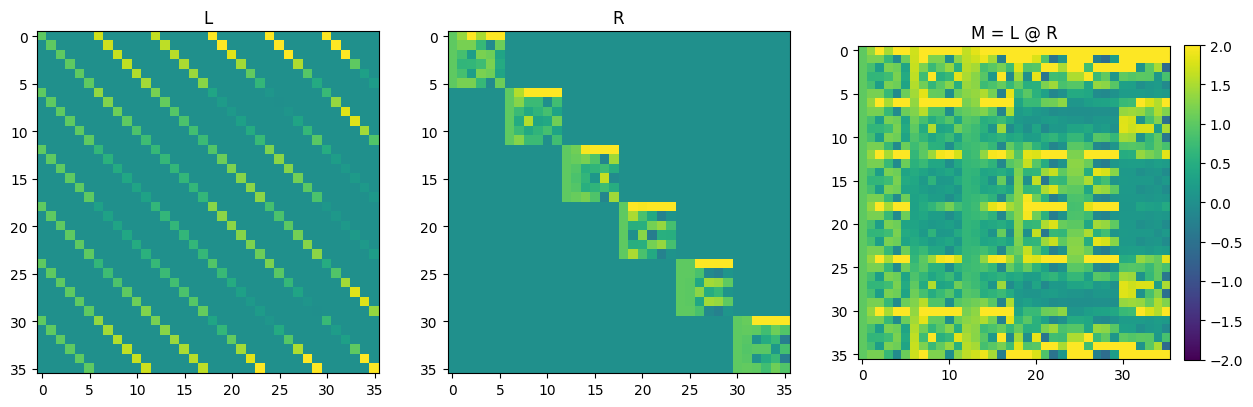

In [16]:
L, R, M, r_polys, l_polys = new_monarch(nearest_square, sqrt_N)
plot_monarch(L.real, R.real, M.real)

In [10]:
def new_monarch(nearest_square, sqrt_N):
    r_polys = [
        [
            torch.rand(i).numpy().tolist() + [1]
            for i in range(sqrt_N)
        ]
        for j in range(sqrt_N)
    ]
    l_polys = [
        torch.rand(j).numpy().tolist() + [1]
        for j in range(sqrt_N)
    ]
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    for i in range(sqrt_N):
        block = torch.zeros(sqrt_N, sqrt_N)
        for j in range(sqrt_N):
            block[:, j] = torch.tensor(np.polyval(r_polys[i][j], omegas[::sqrt_N]))
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block
    for j in range(sqrt_N):
        for i in range(sqrt_N):
            L[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.tensor(np.polyval(l_polys[j], omegas[i * sqrt_N:(i + 1) * sqrt_N])))
    M = L @ R

    return L, R, M, r_polys, l_polys

In [11]:
print('l_polys:')
for i, poly in enumerate(l_polys):
    print(f'l_{i}\t=\t{polystr(poly)}')

print('r_polys:')
for j1, poly in enumerate(r_polys):
    for j0, rpoly in enumerate(poly):
        print(f'r_{j1},{j0}\t=\t{polystr(rpoly)}')

l_polys:
l_0	=	1
l_1	=	0.16x^1 + 1
l_2	=	0.61x^2 + 0.32x^1 + 1
l_3	=	0.91x^3 + 0.04x^2 + 0.9x^1 + 1
l_4	=	0.89x^4 + 0.8x^3 + 0.51x^2 + 0.65x^1 + 1
l_5	=	0.75x^5 + 0.75x^4 + 0.33x^3 + 0.15x^2 + 0.33x^1 + 1
r_polys:
r_0,0	=	1
r_0,1	=	0.63x^1 + 1
r_0,2	=	0.08x^2 + 0.64x^1 + 1
r_0,3	=	0.19x^3 + 0.79x^2 + 0.99x^1 + 1
r_0,4	=	0.85x^4 + 0.28x^3 + 0.94x^2 + 0.55x^1 + 1
r_0,5	=	0.45x^5 + 0.1x^4 + 0.56x^3 + 0.73x^2 + 0.37x^1 + 1
r_1,0	=	1
r_1,1	=	0.94x^1 + 1
r_1,2	=	0.65x^2 + 0.68x^1 + 1
r_1,3	=	0.4x^3 + 0.84x^2 + 0.89x^1 + 1
r_1,4	=	0.31x^4 + 0.3x^3 + 0.94x^2 + 0.98x^1 + 1
r_1,5	=	0.96x^5 + 0.5x^4 + 0.07x^3 + 0.59x^2 + 0.55x^1 + 1
r_2,0	=	1
r_2,1	=	0.45x^1 + 1
r_2,2	=	0.45x^2 + 0.16x^1 + 1
r_2,3	=	0.51x^3 + 0.98x^2 + 0.8x^1 + 1
r_2,4	=	0.11x^4 + 0.04x^3 + 0.37x^2 + 0.86x^1 + 1
r_2,5	=	0.52x^5 + 0.82x^4 + 0.65x^3 + 0.31x^2 + 0.74x^1 + 1
r_3,0	=	1
r_3,1	=	0.42x^1 + 1
r_3,2	=	0.02x^2 + 0.89x^1 + 1
r_3,3	=	0.98x^3 + 0.51x^2 + 0.81x^1 + 1
r_3,4	=	0.36x^4 + 0.04x^3 + 0.95x^2 + 0.44x^1 + 1
r_3,5	=	0.4

In [13]:
# test causality by changing the last element of u, and seeing if the output changes

u = torch.randn(N)
k = torch.randn(N)

M1 = M
M2 = M
M3 = M

y = new_monarch_fft_conv(u, k, N, M1, M2, M3)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(new_monarch_fft_conv(u_changed, k, N, M1, M2, M3))

new_ys = torch.stack(new_ys)

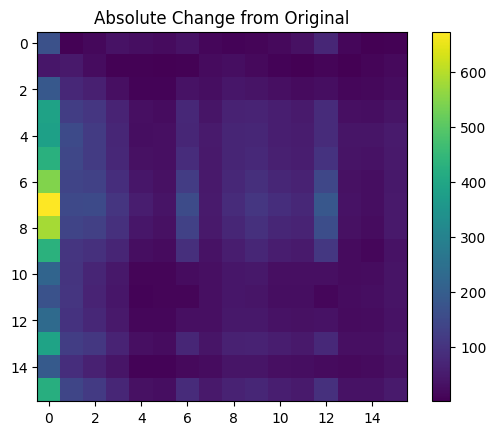

In [14]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()